In [152]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix, classification_report, roc_curve, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier

In [2]:
def f_describe(data, column, feature):
    
    """
    f_describe - describe depending on the feature
    
    """
    
    described_data = pd.DataFrame(index = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max'])
    described = data[[column]].describe()
    
    new_name = "{}".format(column)
    described.rename(columns = {column: new_name}, inplace = True)
    
    if data[feature].nunique() == 1:
        return described
    
    else:
        described_data = pd.concat([described_data, described], axis=1)
        
        
        values = data[feature].unique()
        
        for index, value in enumerate(values):
            new_name = "{}: {}".format(feature, value)
            described = data[data[feature] == value][[column]].describe()
            described.rename(columns = {column: new_name}, inplace = True)
            
            described_data = pd.concat([described_data, described], axis=1)
            
        return described_data

In [3]:
class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold = 0.8):
        self.threshold = threshold
        print("It works!")
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):

        data = pd.DataFrame(X)
        corr_matrix = data.corr(method="spearman")
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        transformed_data = np.array(data.drop(data.columns[to_drop], axis=1))
        
        return transformed_data

In [54]:
def function(y_true, y_pred, discount = 0.2, result = 0):
    
    matrix = confusion_matrix(y_true, y_pred)
    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TN = matrix[1][1]
    
    if result == 0:
        return 1 - (FN + discount*FP)/(TN + discount*TP)
    else:
        return TN - FN + discount*TP - discount*FP

### loading, getting dummies and cleaning data

In [5]:
raw_data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [6]:
data = pd.get_dummies(raw_data, columns=["Churn"], drop_first=True)

In [7]:
data = data[data["TotalCharges"] != " "]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="ignore")

### splitting dataset into train and test sets

In [8]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=44)

data = train_set.drop(["customerID", "Churn_Yes"], axis=1)
data_labels = train_set["Churn_Yes"].copy()

### pipeline, best random forest classifier and feature importances

In [9]:
data_num = data[["tenure", "MonthlyCharges", "TotalCharges"]]
data_cat = data.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])

In [10]:
num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

data_prepared = full_pipeline.fit_transform(data)

In [11]:
params_grid = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 3, 5],
    "min_samples_split": [1, 2, 3, 4],
    "min_samples_leaf": [1, 3, 5], 
    "max_features": [None, "sqrt", "log2"],
    "class_weight": [None, "balanced"],
}

gridsearch = GridSearchCV(estimator = RandomForestClassifier(random_state=44),
                          param_grid = params_grid,
                          scoring = "f1",
                          n_jobs = -1,
                          cv = 5
                         )

gridsearch.fit(data_prepared, data_labels)

C:\Users\nemet\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=44), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [12]:
#gridsearch.best_estimator_
best_rf = RandomForestClassifier(class_weight='balanced',
                                 criterion='entropy',
                                 max_features='log2',
                                 min_samples_leaf=5,
                                 random_state=44)

best_rf.fit(data_prepared, data_labels);

### 10 most important features

In [13]:
transformed_cat_attribs = full_pipeline.named_transformers_["cat"].get_feature_names()
feature_names = np.concatenate((num_attribs, transformed_cat_attribs))

feature_importance_data = pd.DataFrame({"Feature_name": feature_names, "feature_importance": best_rf.feature_importances_})
feature_importance_data = feature_importance_data.sort_values(by="feature_importance", ascending=False)

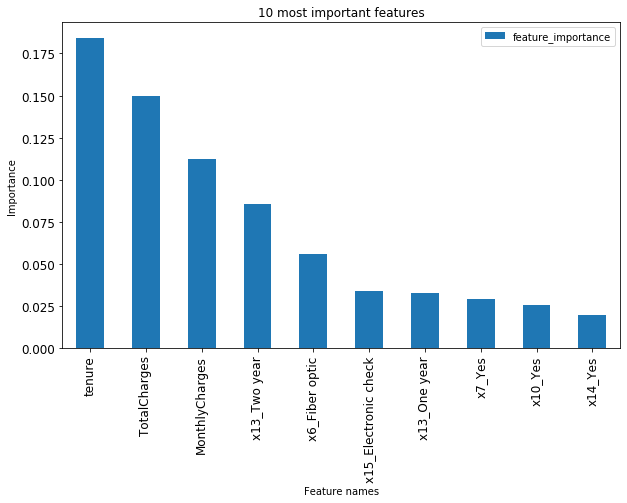

In [14]:
feature_importance_data.iloc[:10,:].plot(x = "Feature_name",
                                         kind = "bar",
                                         figsize = (10, 6),
                                         fontsize = 12,
                                         title = "10 most important features",
                                         xlabel = "Feature names",
                                         ylabel = "Importance");

### MonthlyCharges

In [15]:
pd.options.display.float_format = '{:.2f}'.format
f_desc = f_describe(raw_data, "MonthlyCharges", "Churn")
f_desc

,MonthlyCharges,Churn: No,Churn: Yes
count,7043.00,5174.00,1869.00
mean,64.76,61.27,74.44
std,30.09,31.09,24.67
min,18.25,18.25,18.85
25%,35.50,25.10,56.15
50%,70.35,64.43,79.65
75%,89.85,88.40,94.20
max,118.75,118.75,118.35


In [16]:
mean_diff = round((f_desc.iloc[1,:][2] / f_desc.iloc[1,:][1] * 100) - 100, 2)
median_diff = round((f_desc.iloc[5,:][2] / f_desc.iloc[5,:][1] * 100) - 100, 2)

print("Monthly charges")
print("differences in means: {}%\ndifferences in medians: {}%".format(mean_diff, median_diff))

Monthly charges
differences in means: 21.51%
differences in medians: 23.63%


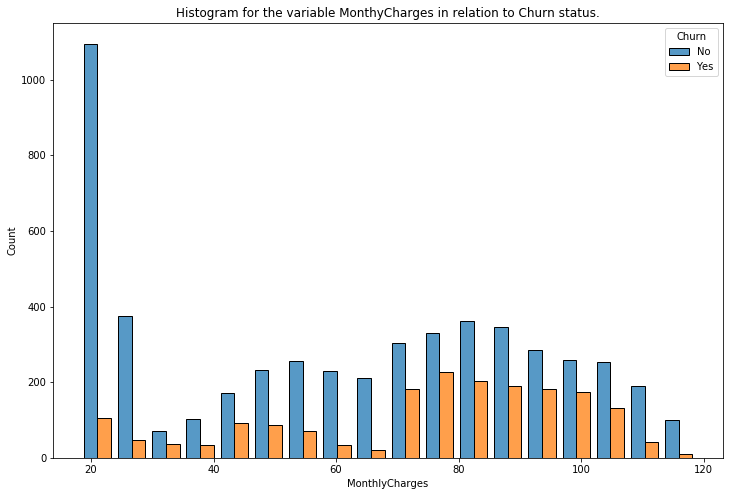

In [17]:
fig = plt.figure(figsize=(12,8))
sns.histplot(data=raw_data, x="MonthlyCharges", hue="Churn", multiple="dodge", shrink=0.8);
plt.title("Histogram for the variable MonthyCharges in relation to Churn status.");

### pipeline, splitting prepared data into train and validation sets

In [18]:
full_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("poly", PolynomialFeatures(degree=5,
                                    include_bias=False,
                                    interaction_only=False)),
        ("scaler", StandardScaler()),
    ]), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

new_data = full_pipeline.fit_transform(data)

In [19]:
pipeline = Pipeline([("droper", DropTransformer(threshold = 0.9))])

data_prepared = pipeline.fit_transform(new_data)

It works!


In [93]:
X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size = 0.25,
                                                  random_state=44, stratify=data_labels)

### metric selection

In [21]:
sample_model = KNeighborsClassifier()

sample_model.fit(X_train, y_train);

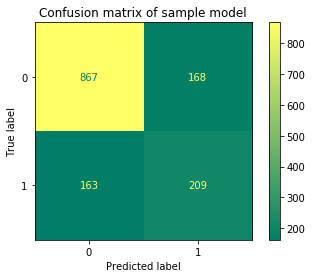

In [22]:
plot_confusion_matrix(sample_model, X_val, y_val, cmap="summer");
plt.title("Confusion matrix of sample model");

### Slytherin score

$$ score = \frac{TN - FN + d\cdot TP - d\cdot FP}{TN + d\cdot TP} = 1 - \frac{FN + d\cdot FP}{TN + d\cdot TP}$$

$d$ - discount  
$TN$ - clients who were detected as satisfied, and they really are.  
$FN$ - clients who were detected as satisfied, but they left.  
$TP$ - clients who were detected as dissatisfied - they are entitled to a discount.  
$FP$ -  clients who were detected as dissatisfied - they are entitled to a discount even though they are satisfied.  

In [23]:
slytherin_score = make_scorer(function)

### F1 vs slytherin

In [24]:
params_grid = {
    "C": [0.1, 0.2, 0.5, 1],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [1, 2, 3],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"]
}

gridsearch_f1 = GridSearchCV(estimator = SVC(random_state=44),
                             param_grid = params_grid,
                             scoring = "f1",
                             n_jobs = -1,
                             verbose = 1,
                             cv = 5
                            )

gridsearch_f1.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1],
                         'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1', verbose=1)

In [25]:
params_grid = {
    "C": [0.1, 0.2, 0.5, 1],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [1, 2, 3],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"]
}

gridsearch_ss = GridSearchCV(estimator = SVC(random_state=44),
                             param_grid = params_grid,
                             scoring = slytherin_score,
                             n_jobs = -1,
                             verbose = 1,
                             cv = 5
                            )

gridsearch_ss.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1],
                         'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring=make_scorer(function), verbose=1)

In [26]:
f1_results = pd.DataFrame(gridsearch_f1.cv_results_)[["params", "mean_test_score", "std_test_score"]]
f1_results = f1_results.rename(columns={"params": "params_f1",
                                        "mean_test_score": "mean_test_score_f1",
                                        "std_test_score": "std_test_score_f1"
                                       })


ss_results = pd.DataFrame(gridsearch_ss.cv_results_)[["params", "mean_test_score", "std_test_score"]]
ss_results = ss_results.rename(columns={"params": "params_ss",
                                        "mean_test_score": "mean_test_score_ss",
                                        "std_test_score": "std_test_score_ss"
                                       })

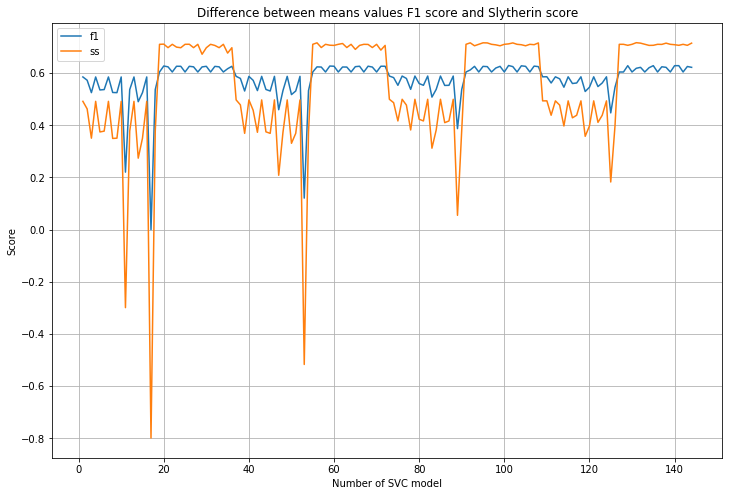

In [27]:
comparison = pd.concat([f1_results, ss_results], axis=1)

X = range(1, len(comparison)+1)
y_f1 = comparison["mean_test_score_f1"]
y_ss = comparison["mean_test_score_ss"]

fig = plt.figure(figsize=(12, 8))
sns.lineplot(x = X, y = y_f1, label = "f1")
sns.lineplot(x = X, y = y_ss, label = "ss")
plt.grid()
plt.title("Difference between means values F1 score and Slytherin score");
plt.xlabel("Number of SVC model");
plt.ylabel("Score");

### KNN

In [55]:
%%time

grid_params = {
    "n_neighbors": [5, 11, 19, 21, 23, 25, 31, 41, 51],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
    "leaf_size": list(range(10, 50, 10)),
    "p": [1, 2]
}

knn_classifier = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    scoring = slytherin_score,
    verbose = 1,
    cv = 5,
    n_jobs = -1
)

knn_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Wall time: 28.1 s


In [56]:
knn_classifier.best_estimator_

KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=41, p=1)

In [57]:
best_knn_classifier = KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=41, p=1);

best_knn_classifier.fit(X_train, y_train);
slytherin_score(best_knn_classifier, X_val, y_val)

0.5546679980029956

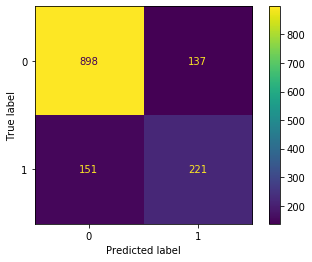

In [58]:
plot_confusion_matrix(best_knn_classifier, X_val, y_val)

### RF

In [60]:
params_grid = {
    'max_depth': [None,3,5,7,9,10,12,14,17,20],
    'class_weight': [None,'balanced'],
    'max_features': [None,'auto','log2'],
    'min_samples_leaf': [1,3,5,10,15,20]
}

rf_classifier = GridSearchCV(RandomForestClassifier(),
                             param_grid=params_grid,
                             scoring=slytherin_score,
                             verbose = 1,
                             n_jobs=-1,
                             cv=5
                            )

rf_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 3, 5, 7, 9, 10, 12, 14, 17, 20],
                         'max_features': [None, 'auto', 'log2'],
                         'min_samples_leaf': [1, 3, 5, 10, 15, 20]},
             scoring=make_scorer(function), verbose=1)

In [61]:
rf_classifier.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,
                       min_samples_leaf=5)

In [62]:
best_rf_classifier = RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=5);

best_rf_classifier.fit(X_train, y_train);
slytherin_score(best_rf_classifier, X_val, y_val)

0.7161862527716186

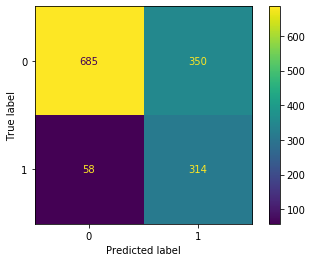

In [63]:
plot_confusion_matrix(best_rf_classifier, X_val, y_val)

### SVM

In [64]:
params_grid = {
    "C": [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 2],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "probability": [True],
    "class_weight": [None, "balanced"]
}

svm_classifier = GridSearchCV(estimator = SVC(random_state=44),
                          param_grid = params_grid,
                          scoring = slytherin_score,
                          n_jobs = -1,
                          verbose = 1,
                          cv = 5
                         )

svm_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 2],
                         'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             scoring=make_scorer(function), verbose=1)

In [65]:
svm_classifier.best_estimator_

SVC(C=0.25, class_weight='balanced', degree=1, kernel='poly', probability=True,
    random_state=44)

In [66]:
best_svm_classifier = SVC(C=0.25, class_weight='balanced', degree=1, kernel='poly', probability=True, random_state=44)

best_svm_classifier.fit(X_train, y_train);
slytherin_score(best_svm_classifier, X_val, y_val)

0.7178919397697077

In [140]:
function(y_val, best_svm_classifier.predict(X_val), result=1)

324.20000000000005

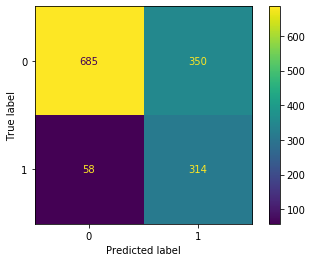

In [129]:
plot_confusion_matrix(best_rf_classifier, X_val, y_val)

### Models comparison

In [90]:
knn_clf = KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=41, p=1)
xgb_clf = XGBClassifier(n_estimators=10, booster="gblinear", random_state=44, scale_pos_weight=3, eval_metric = "error", use_label_encoder=False)
log_clf = LogisticRegression(C=0.5, solver="liblinear", class_weight="balanced", random_state=44)
rnd_clf = RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=5)
svm_clf = SVC(C=0.25, class_weight='balanced', degree=1, kernel='poly', probability=True, random_state=44)

In [91]:
models = []
results = []
names = []

models.append(("KNN", knn_clf))
models.append(("XGB", xgb_clf))
models.append(("LR", log_clf))
models.append(("RF", rnd_clf))
models.append(("SVM", svm_clf))

scoring = slytherin_score

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=44);
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.543289 (0.070366)
XGB: 0.723101 (0.039288)
LR: 0.716639 (0.045311)
RF: 0.716320 (0.037114)
SVM: 0.718036 (0.032865)


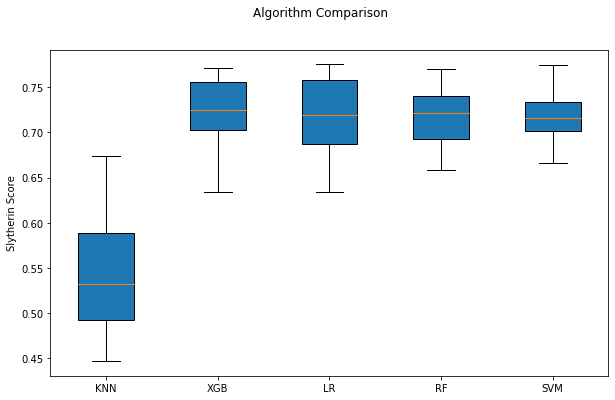

In [92]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, vert=True, patch_artist=True);
ax.set_xticklabels(names)
ax.set_ylabel("Slytherin Score")
plt.show();

### Meta learning

In [99]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size = 0.5,
                                                        random_state=44, stratify=y_train)

In [141]:
estimators = [xgb_clf, log_clf, rnd_clf, svm_clf]

for estimator in estimators:
    print("Training the: {}\n ".format(estimator))
    estimator.fit(X_train1, y_train1);

Training the: XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='error', gamma=None,
              gpu_id=-1, importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=6, num_parallel_tree=None, predictor=None,
              random_state=44, reg_alpha=0, reg_lambda=0, scale_pos_weight=3,
              subsample=None, tree_method=None, use_label_encoder=False,
              validate_parameters=1, verbosity=None)
 
Training the: LogisticRegression(C=0.5, class_weight='balanced', random_state=44,
                   solver='liblinear')
 
Training the: RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,
                       min_samples_leaf=5)
 
Traini

In [142]:
X_train_predictions = np.empty((len(X_train2), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_train_predictions[:, index] = estimator.predict(X_train2)
    
X_train_predictions

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)

In [143]:
params_grid = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [1, 2, 3, 4, 5],
    "min_samples_leaf": [1, 3, 5, 7, 10], 
    "max_features": [None, "sqrt", "log2"],
    "class_weight": [None, "balanced"],
}

gridsearch = GridSearchCV(estimator = RandomForestClassifier(oob_score=True, random_state=44),
                          param_grid = params_grid,
                          scoring = slytherin_score,
                          n_jobs = -1,
                          verbose = 1,
                          cv = 5
                         )

gridsearch.fit(X_train_predictions, y_train2)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits


C:\Users\nemet\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=44),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 5, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5, 7, 10],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(function), verbose=1)

In [144]:
gridsearch.best_estimator_

RandomForestClassifier(class_weight='balanced', max_features=None,
                       min_samples_leaf=10, oob_score=True, random_state=44)

In [145]:
best_classifier = RandomForestClassifier(class_weight='balanced',
                                         max_depth=3,
                                         max_features='sqrt',
                                         n_estimators=200,
                                         oob_score=True,
                                         random_state=44)

best_classifier.fit(X_train_predictions, y_train2);

In [146]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [147]:
slytherin_score(best_classifier, X_val_predictions, y_val)

0.6935920577617329

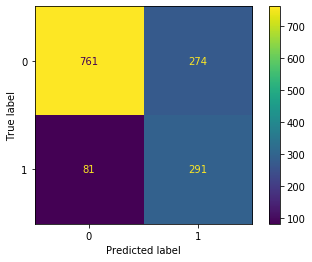

In [148]:
plot_confusion_matrix(best_classifier, X_val_predictions, y_val)

### Ensemble Learning

In [ ]:
knn_clf = KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=41, p=1)
xgb_clf = XGBClassifier(n_estimators=10, booster="gblinear", random_state=44, scale_pos_weight=3, eval_metric = "error", use_label_encoder=False)
log_clf = LogisticRegression(C=0.5, solver="liblinear", class_weight="balanced", random_state=44)
rnd_clf = RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=5)
svm_clf = SVC(C=0.25, class_weight='balanced', degree=1, kernel='poly', probability=True, random_state=44)

In [149]:
voting_clf = VotingClassifier(
    estimators=[("knc", knn_clf), ("xgb", xgb_clf), ("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard")

In [155]:
print("   model   ", "   accuracy   ", "   recall   ")
for clf in (knn_clf, xgb_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, round(f1_score(y_val, y_pred),5), round(function(y_val, y_pred), 5))

   model       accuracy       recall   
KNeighborsClassifier 0.60548 0.55467
XGBClassifier 0.61145 0.69771
LogisticRegression 0.62292 0.70817
RandomForestClassifier 0.6069 0.70759
SVC 0.61281 0.71789
VotingClassifier 0.61618 0.69888


In [153]:
function(y_val, y_pred)

0.7081659973226238

In [156]:
voting_clf = VotingClassifier(
    estimators=[("xgb", xgb_clf), ("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard")

In [157]:
print("   model   ", "   accuracy   ", "   recall   ")
for clf in (xgb_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, round(f1_score(y_val, y_pred),5), round(function(y_val, y_pred), 5))

   model       accuracy       recall   
XGBClassifier 0.611 0.69888
LogisticRegression 0.62292 0.70817
RandomForestClassifier 0.59204 0.71104
SVC 0.61281 0.71789
VotingClassifier 0.61634 0.70063
